In [9]:
from time import sleep
import google.generativeai as genai
import configparser
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
# leer archivo config.ini
config = configparser.ConfigParser()
config.read('config.ini')
GOOGLE_API_KEY = config['GOOGLE']['GOOGLE_API_KEY']
genai.configure(api_key=GOOGLE_API_KEY)
model = genai.GenerativeModel('gemini-2.0-flash')

In [43]:
consulta = "Como titular del vehículo dominio GXG594, y a raíz de la necesidad de regularizar mi situación y abonar voluntariamente mis infracciones, es que realizo el presente descargo. Solicito la revisión y resolución favorable ante la infracción que se me adjudica de \"invadir carril exclusivo\", siendo que dicha situación se perpetuó solo un instante, el necesario para ingresar al estacionamiento perteneciente a La Mutual de Empleados Públicos de Rosario, ubicada en calle San Lorenzo 1543. Soy músico, y la infracción que me reclaman se dio en el marco de un ensayo y prueba de sonido previa al concierto que fue la noche del 1/12/23. La mutual nos puso a disposición las cocheras de la comisión en el estacionamiento pegado a dicha institución. La única forma de acceder era cruzando de carril para poder ingresar. Situación que se dio en solo segundos. "

prompt = f"""
Se le proporcionará un descargo realizado por un vecino en el sitio web de la municipalidad, en respuesta a una infracción o multa.

A partir del texto entre triple comilla invertida, determine lo siguiente:
1. Si la persona expresa voluntad de pagar la multa.
2. Si la persona está ofreciendo una justificación o excusa respecto a la infracción.
3. El sentimiento general del texto (por ejemplo: enojado, frustrado, resignado, neutral, etc.).

Texto: '''{consulta}'''

Devuelva la respuesta en formato JSON con la siguiente estructura:
  "Quiere pagar": "Sí" o "No",
  "Quiere justificar": "Sí" o "No",
  "Sentimiento": "..."
"""
response = model.generate_content(
        prompt,
        generation_config = genai.GenerationConfig(
        temperature=0.0,
        )
    )

print(response.text)

```json
{
  "Quiere pagar": "Sí",
  "Quiere justificar": "Sí",
  "Sentimiento": "Justificativo/Explicativo"
}
```


Recorrer la lista de consultas de habilitaciones y obtener tematicas claves y sentimientos de las mismas


In [44]:
data = pd.read_excel('Descargos Ene-Feb 2025.xlsx')
data.head(5)

,tramite_tipo_id,codigo_gestion,solicitante_cuit,destinatario_cuit,fecha_presentacion,fecha_fin,descargo,patente
0,129,79512-2025,20140824756,20140824756,2025-02-06 08:23:37.196,2025-02-11 13:13:42.14,"""Que no soy oriundo de la ciudad de Rosario, d...","""AF365QY"""
1,75,77568-2025,27345723981,27345723981,2025-02-05 15:23:39.688,2025-02-07 12:13:09.222,"""Se realizan dos multas del mismo día, en el m...","""AF682GM"""
2,75,79556-2025,20206773260,20206773260,2025-02-06 09:43:37.703,2025-02-12 11:23:44.889,"""El día 29/01/2025, de confección del acta, el...","""AG956JC"""
3,75,69997-2025,20438423118,20438423118,2025-02-03 10:39:51.8,2025-02-07 08:24:55.675,"""Buenos días, me acaban de echar del trabajo y...","""A111ECW"""
4,75,65844-2025,20174607096,20174607096,2025-01-31 20:23:44.277,2025-02-05 12:40:42.898,"""Solicito la anulación de la infracción.\r\nEs...","""AC906BQ """


In [46]:
# recorrer todo el dataframe data y extraer la intencion y sentimientos

for i, row in data.iterrows():

    consulta = data['descargo'][i]
    # extraer comillas dobles de la consulta
    consulta = re.sub(r'\"', '', consulta)

    # si la consulta es nula o el largo de la consulta es menor a 10 caracteres no la proceso
    if pd.isnull(consulta) or len(consulta) < 10:
        continue 
    print(i, consulta)
    prompt = f"""
    Se le proporcionarán descargos de vecinos por multas al sitio web de la municipalidad.
    En base al siguiente texto, que está delimitado por tres comillas invertidas, determine si las personas quieren pagar la multa o bien, se están justificando o excusandose de la infracción.
    Indique el sentimiento general del texto en una palabra.
    Texto: '''{consulta}'''

    El formato de salida es JSON, con los siguientes campos:
    "Quiere pagar": "Si/No"
    "Quiere justificar": "Si/No"
    "Sentimientos": 
    """
    
    response = model.generate_content(
        prompt,
        generation_config = genai.GenerationConfig(
        temperature=0.0,
        )
                                      )
    print(response.text)
    # Extraer el contenido JSON del Markdown
    markdown_text = response.text

    # Usar una expresión regular para extraer el contenido JSON
    json_match = re.search(r'```json\n(.*?)\n```', markdown_text, re.DOTALL)
    if json_match:
        json_string = json_match.group(1)
        try:
            # Convertir la cadena de texto a un objeto JSON
            analisis = json.loads(json_string)
            # Agregar respuesta al dataframe data por cada campo de response.text
            data.loc[i, 'Quiere pagar'] = analisis.get('Quiere pagar', 'None')
            data.loc[i, 'Quiere justificar'] = analisis.get('Quiere justificar', 'None')            
            data.loc[i, 'Sentimientos'] = ', '.join(analisis.get('Sentimientos', [])) if isinstance(analisis.get('Sentimientos', []), list) else analisis.get('Sentimientos', 'None')

        except json.JSONDecodeError as e:
            print(f"Error al decodificar JSON: {e}")
    else:
        print("No se encontró contenido JSON en la respuesta.")

    sleep(5) # para no exceder la cuota de Google de 15 requests por minuto
    if i>300:
        break

# guardar el dataframe data con las respuestas en un archivo Excel
data.to_excel('Descargos-procesado-gemini-2.0-flash.xlsx', index=False)


0 Que no soy oriundo de la ciudad de Rosario, de modo circunstancial me encontraba circulando por la ciudad por lo que puede que haya cometido alguna infracción según las ordenanzas locales, por desconocimiento. Solicito se aplique una reducción en la pena aplicada a los fines de poder hacer frente a la misma.
```json
{
  "Quiere pagar": "Si",
  "Quiere justificar": "Si",
  "Sentimientos": "Arrepentimiento"
}
```

1 Se realizan dos multas del mismo día, en el mismo lugar con diferencia horaria, utilizando en una la foto delantera del auto y en la segunda la foto trasera. Se está cobrando la misma infracción dos veces utilizando dos fotos diferentes donde se ve que el auto está en el mismo lugar en ambas.
```json
{
  "Quiere pagar": "No",
  "Quiere justificar": "Si",
  "Sentimientos": "Indignación"
}
```

2 El día 29/01/2025, de confección del acta, el vehículo se encontraba en calle Paraguay al 1100, retenido por la Comisaría 2da por indicación de personal policial, del cual se adjunta

In [47]:
data = pd.read_excel('Descargos-procesado-gemini-2.0-flash.xlsx')
data.head(5)

,tramite_tipo_id,codigo_gestion,solicitante_cuit,destinatario_cuit,fecha_presentacion,fecha_fin,descargo,patente,Quiere pagar,Quiere justificar,Sentimientos
0,129,79512-2025,20140824756,20140824756,2025-02-06 08:23:37.196,2025-02-11 13:13:42.14,"""Que no soy oriundo de la ciudad de Rosario, d...","""AF365QY""",Si,Si,Arrepentimiento
1,75,77568-2025,27345723981,27345723981,2025-02-05 15:23:39.688,2025-02-07 12:13:09.222,"""Se realizan dos multas del mismo día, en el m...","""AF682GM""",No,Si,Indignación
2,75,79556-2025,20206773260,20206773260,2025-02-06 09:43:37.703,2025-02-12 11:23:44.889,"""El día 29/01/2025, de confección del acta, el...","""AG956JC""",No,Si,Justificación
3,75,69997-2025,20438423118,20438423118,2025-02-03 10:39:51.8,2025-02-07 08:24:55.675,"""Buenos días, me acaban de echar del trabajo y...","""A111ECW""",Si,Si,Necesidad
4,75,65844-2025,20174607096,20174607096,2025-01-31 20:23:44.277,2025-02-05 12:40:42.898,"""Solicito la anulación de la infracción.\r\nEs...","""AC906BQ """,No,Si,Justificación


In [48]:
# armar dataframe con las columnas Quiere pagar, codigo_gestion, Quiere justificar y Sentimientos y de los registros que tengan datos en esas columnas
data1 = data[['codigo_gestion', 'Quiere pagar', 'Quiere justificar', 'Sentimientos']]
data1

,codigo_gestion,Quiere pagar,Quiere justificar,Sentimientos
0,79512-2025,Si,Si,Arrepentimiento
1,77568-2025,No,Si,Indignación
2,79556-2025,No,Si,Justificación
3,69997-2025,Si,Si,Necesidad
4,65844-2025,No,Si,Justificación
...,...,...,...,...
2588,79400-2025,NaN,NaN,NaN
2589,79421-2025,NaN,NaN,NaN
2590,63438-2025,NaN,NaN,NaN
2591,63492-2025,NaN,NaN,NaN


In [49]:
# filtrar los registros que tengan datos en esas columnas
data2 = data1[data1['Quiere pagar'].notnull()]
data2


,codigo_gestion,Quiere pagar,Quiere justificar,Sentimientos
0,79512-2025,Si,Si,Arrepentimiento
1,77568-2025,No,Si,Indignación
2,79556-2025,No,Si,Justificación
3,69997-2025,Si,Si,Necesidad
4,65844-2025,No,Si,Justificación
...,...,...,...,...
297,92623-2025,Si,Si,NaN
298,92643-2025,No,Si,Justificación
299,92649-2025,No,Si,Justificación
300,73244-2025,No,Si,Duda


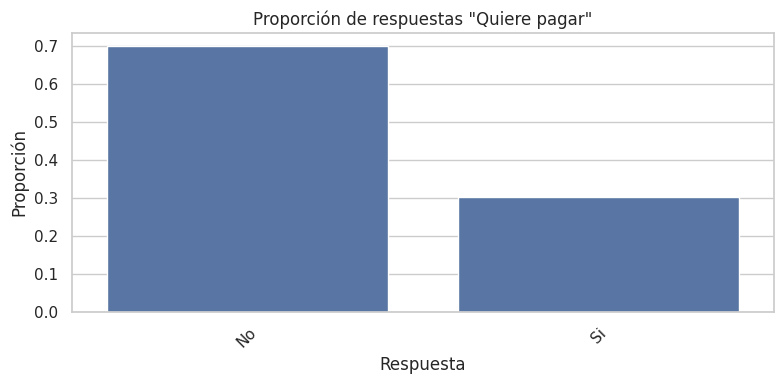

In [50]:
# Calcular cantidad y proporción por categoría en la columna 'Quiere pagar'
resumen_df = (
    data2['Quiere pagar']
    .value_counts(normalize=False)
    .rename_axis('Quiere pagar')
    .reset_index(name='Cantidad')
)
resumen_df['Proporcion'] = resumen_df['Cantidad'] / resumen_df['Cantidad'].sum()

# Visualización
sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))
sns.barplot(x='Quiere pagar', y='Proporcion', data=resumen_df)
plt.title('Proporción de respuestas "Quiere pagar"')
plt.xlabel('Respuesta')
plt.ylabel('Proporción')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


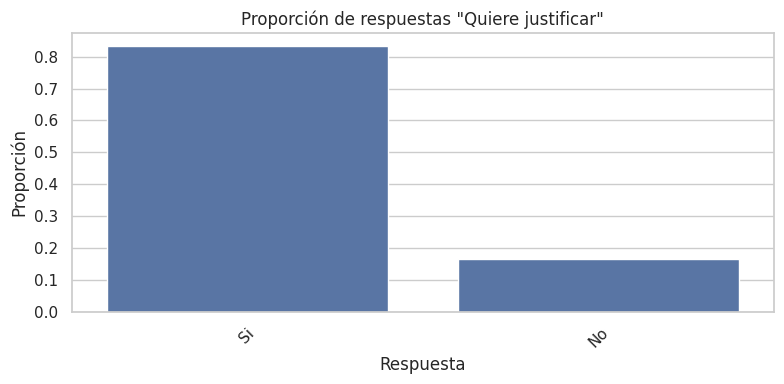

In [27]:
# Calcular cantidad y proporción por categoría en la columna 'Quiere pagar'
resumen_df = (
    data2['Quiere justificar']
    .value_counts(normalize=False)
    .rename_axis('Quiere justificar')
    .reset_index(name='Cantidad')
)
resumen_df['Proporcion'] = resumen_df['Cantidad'] / resumen_df['Cantidad'].sum()

# Visualización
sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))
sns.barplot(x='Quiere justificar', y='Proporcion', data=resumen_df)
plt.title('Proporción de respuestas "Quiere justificar"')
plt.xlabel('Respuesta')
plt.ylabel('Proporción')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- probar el mismo prompt con gemini-2.0-flash y con openai para ver si cambian las proporciones de los que quieren pagar o no

